In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
# Create a list to store individual stock DataFrames
def yahoo_download(ticks):
    """
    yahoo_download downloads the tickers in ticks and stores them in a dataframe.
    """
    # Fetch the list of S&P 500 tickers from Wikipedia
    df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    tickers = df['Symbol'].tolist()
    
    equities = []
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, period = '3y')['Adj Close']
            stock_data.name = ticker  # Rename the Series to match the ticker
            equities.append(stock_data)
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")

    # Concatenate all the individual DataFrames
    closing_prices = pd.concat(equities, axis=1)
    return closing_prices

# Read pickle file if exists, otherwise download stocks from Yahoo Finance
try:
    closing_prices = pd.read_pickle("./closing_prices_SP500.pkl")
except FileNotFoundError:
    closing_prices = yahoo_download(tickers)

# Drop rows with any missing values for consistency
closing_prices.dropna(axis=1, inplace=True)
closing_prices.to_pickle("./closing_prices_SP500.pkl")


In [141]:
def get_rolling_average(dataframe,nodays):
    dfnew = dataframe.copy()
    cols = dfnew.columns
    for c in cols:
        dfnew[c]=dfnew[c].rolling(nodays,center=True).mean()
    dfnew = dfnew.dropna(axis='rows')
    return dfnew

In [143]:
def prices_to_perc_change(prices):
    return [100*(prices[i+1]-prices[i])/prices[i] for i in range(len(prices)-1)]

def convert_to_perc(dataframe):
    return pd.DataFrame({t:prices_to_perc_change(closing_prices[t]) for t in closing_prices.columns})

There may be external factors that force all prices to change more than they normally would on certain days; we can eliminate that variation by normalizing the rows wrt to the L1 norm.

In [152]:
def l1_row_normalization(dataframe):
    dft = dataframe.T.copy()
    maxpercchanges = {i:max((dft[i].apply(abs)).values) for i in dft.columns}
    for i in dft.columns:
        dft[i] = dft[i]/maxpercchanges[i]
    return dft.T

def convert_perc_normalized(dataframe):
    return l1_row_normalization(convert_to_perc(dataframe))

In [156]:
def l2_normalization(dataframe):
    dfn = dataframe.copy()
    for ticker in dfn:
        dfn[ticker] = dfn[ticker]/np.linalg.norm(dfn[ticker])
    return dfn

def normalize_transpose(dataframe):
    return l2_normalization(dataframe).T

In [157]:
dfs = [normalize_transpose(get_rolling_average(closing_prices,d)) for d in [3,5,7]]
silhouette_scores = [[] for d in [3,5,7]]
noclusters = [i for i in range(3,61)]
for i in noclusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    for j in [0,1,2]:
        df = dfs[j]
        ypred = kmeans.fit(df)
        labels = kmeans.labels_
        score = metrics.silhouette_score(df, labels, metric = 'euclidean')
        silhouette_scores[j].append(score)


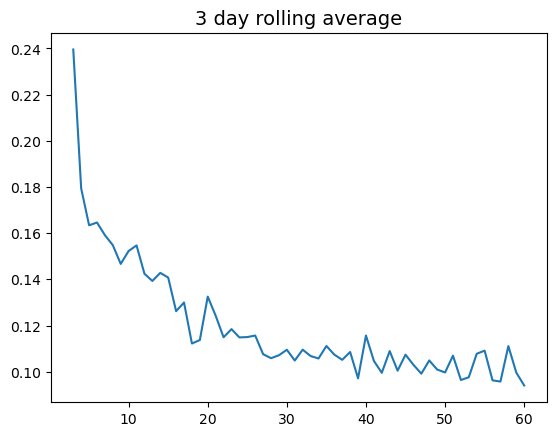

In [166]:
plt.plot(noclusters, silhouette_scores[0])
plt.title("3 day rolling average", fontsize=14)

plt.show()

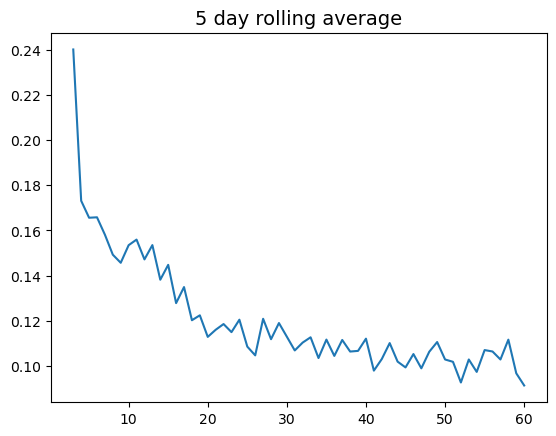

In [165]:
plt.plot(noclusters, silhouette_scores[1])
plt.title("5 day rolling average", fontsize=14)

plt.show()

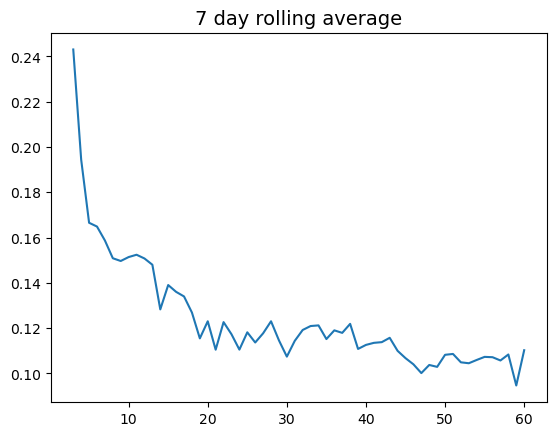

In [164]:
plt.plot(noclusters, silhouette_scores[2])
plt.title("7 day rolling average", fontsize=14)

plt.show()